In [123]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [124]:
data = pd.read_csv('./diabetes.csv') 

In [125]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

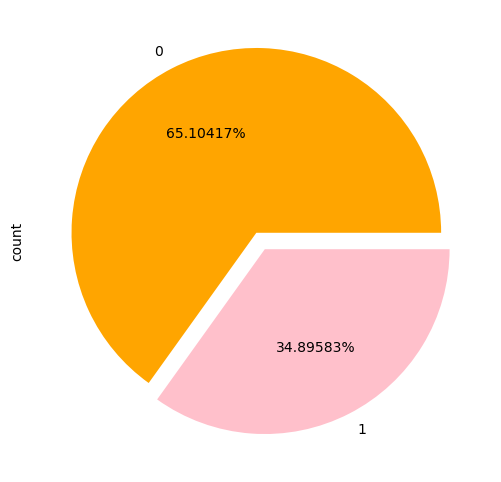

In [126]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['orange', 'pink'], explode=(0.05, 0.05))

In [127]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [128]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [129]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [130]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [131]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
# y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
# y_test = torch.tensor(y_train, dtype=torch.int64)

In [132]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [133]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [134]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [135]:
criterion = nn.BCEWithLogitsLoss()
# CrossEntropyLoss 다중 분류
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            # [이진 분류용] sigmoid + 0.5 기준
            predicted = (torch.sigmoid(outputs) >= 0.5).float()

            # [다중 분류용] 클래스 점수 중 최대값 인덱스
            # _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.1559, Accuracy: 74.68%
Epoch 2/20, Loss: 0.1572, Accuracy: 75.32%
Epoch 3/20, Loss: 0.1542, Accuracy: 75.32%
Epoch 4/20, Loss: 0.1519, Accuracy: 75.32%
Epoch 5/20, Loss: 0.1618, Accuracy: 75.32%
Epoch 6/20, Loss: 0.1514, Accuracy: 75.32%
Epoch 7/20, Loss: 0.1466, Accuracy: 74.68%
Epoch 8/20, Loss: 0.1468, Accuracy: 75.97%
Epoch 9/20, Loss: 0.1476, Accuracy: 74.68%
Epoch 10/20, Loss: 0.1482, Accuracy: 74.68%
Epoch 11/20, Loss: 0.1862, Accuracy: 75.32%
Epoch 12/20, Loss: 0.1489, Accuracy: 74.03%
Epoch 13/20, Loss: 0.1446, Accuracy: 74.68%
Epoch 14/20, Loss: 0.1463, Accuracy: 74.03%
Epoch 15/20, Loss: 0.1532, Accuracy: 74.03%
Epoch 16/20, Loss: 0.1445, Accuracy: 72.73%
Epoch 17/20, Loss: 0.1516, Accuracy: 74.68%
Epoch 18/20, Loss: 0.1470, Accuracy: 75.97%
Epoch 19/20, Loss: 0.1431, Accuracy: 74.68%
Epoch 20/20, Loss: 0.1459, Accuracy: 74.68%
Training complete.


In [144]:
with torch.no_grad():
    outputs = model(X_test)
    outputs = torch.sigmoid(outputs)
    predicted = (outputs >= 0.5).float()

    correct = (predicted == y_test).sum()
    accuracy = correct / y_test.size(0)

    print(f'\nTest Accuracy: {accuracy:.4f}\n')

    # Confusion matrix 및 메트릭 계산
    y_true = y_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print("Confusion Matrix:")
    print(cm)
    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')


Test Accuracy: 0.7468

Confusion Matrix:
[[88 19]
 [20 27]]
F1 Score: 0.58
Precision: 0.59
Recall: 0.57


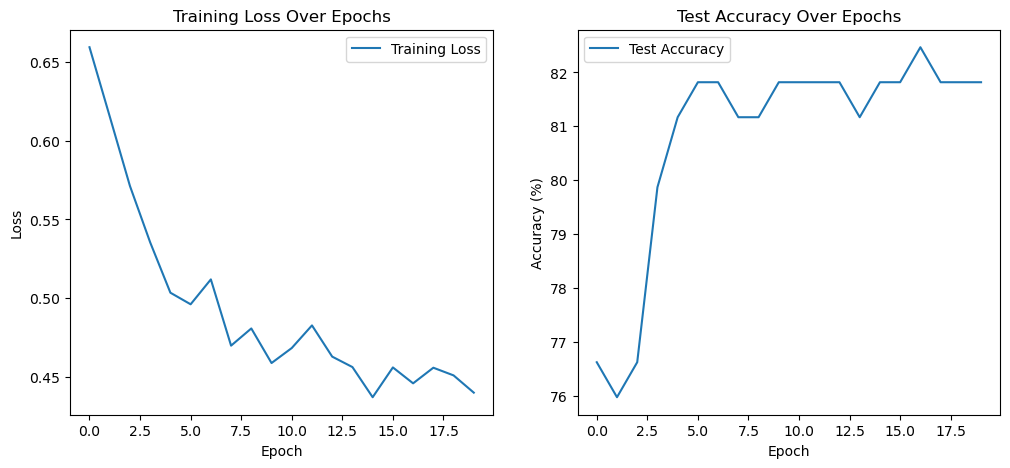

In [138]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()